In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import Series
from pandas import DataFrame
import statsmodels.api as sm
import matplotlib.pyplot as plt
import tensorflow as tf
from statsmodels.tsa.stattools import adfuller  #ADF check stationality
from statsmodels.tsa.seasonal import seasonal_decompose # fenjie
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.arima_model import ARIMA  # 导入ARIMA模型
from statsmodels.tsa.api import SARIMAX
from pandas.core import datetools
from sklearn import svm
from zodbpickle import pickle

c:\users\ctbri\gc\python3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
## part1: June. no resid

# SARIMA(0,1,0)*(2,1,1) 24
# test_point = 150
# train_set error: 32.6%
# test_set error : 37.7%

In [3]:
# work 1. load ts data
f = open('ts_June.data', 'rb')
ts_06 = pickle.load(f)
f.close()
ts_06 = ts_06.replace(0, 1)
len(ts_06) # 720 

720

In [4]:
# diff
ts_diff_06 = ts_06.diff(24)
ts_diff_06.dropna(inplace = True)  # remove first 24 items. then len(ts_diff) = 696
ts_diff_06 = ts_diff_06.replace(0, 1) # replace 0 with 1. for easier error analysis

In [5]:
# work 2. check ACF PACF of ts_diff . then fix the parameters of SARIMA

#plot_acf(ts_diff, lags = 100)
#plot_pacf(ts_diff, lags = 100)

# ARIMA(1,0,4) * (3,1,2) 24

In [6]:
#ts = ts[24:]

In [7]:
# work 3. fit model using original ts[:-100].
# last 100 points seemed as test_data
pdq_06 = (0,1,0)
PDQ_06 = (2,1,1,24)

test_point_06 = 150
train_point_06 = len(ts_06) - test_point_06 # 620 - 24
train_06, test_06 = ts_06[:train_point_06], ts_06[train_point_06 :] #divide data into train_set and test_set

# fit model and predict
model_train_06 = SARIMAX(train_06, order = pdq_06, seasonal_order = PDQ_06 ).fit() # fitted model for predicting
predict_train_06 = model_train_06.fittedvalues # prediction on train test # first 100(24) needs to be deleted
predict_test_06 = model_train_06.forecast(test_point_06)  #  prediction on test set
predict_all_arima_06 = model_train_06.fittedvalues.append(predict_test_06) # predict on all data set (including train and test )

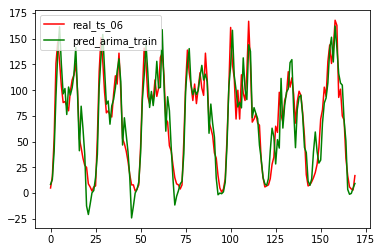

In [8]:
# in-sample results

plt.plot(ts_06.values[100:270], color = 'red', label = 'real_ts_06')
plt.plot(predict_train_06.values[100:270], color = 'green', label = 'pred_arima_train')
#plt.plot(predict_train.values[24:200], color = 'green', label = 'lag_pred_arima')
plt.legend(loc = 'upper left')

In [9]:
# in-sample error rate
# only SARIMA
np.mean(abs(ts_06[100:train_point_06]-predict_train_06[100:train_point_06])/ts_06[100:train_point_06])

0.33020675216504797

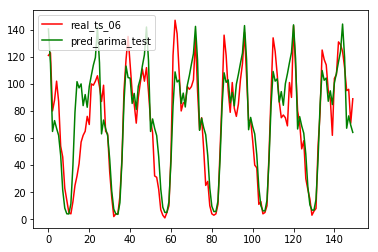

In [10]:
# out-of-sample results

plt.plot(ts_06.values[-test_point_06:], color = 'red', label = 'real_ts_06')
plt.plot(predict_test_06.values[-test_point_06:], color = 'green', label = 'pred_arima_test')
#plt.plot(predict_train.values[24:200], color = 'green', label = 'lag_pred_arima')
plt.legend(loc = 'upper left')

In [11]:
# out-of-sample error rate
# only SARIMA
np.mean(abs(ts_06[-test_point_06:]-predict_test_06[-test_point_06:])/ts_06[-test_point_06:])

0.37718197394745706

In [12]:
# work. residual
# residual consists of both train and test part of ARIMA
residual_06 = ts_06 - predict_all_arima_06 
residual_06 = residual_06[100:]

n = 30 # how to set???
residual_list_06 = []
for i in np.arange(n - 1,  len(residual_06)):
    for j in np.arange( -(n - 1),  1):
        residual_list_06.append(residual_06[i + j] ) # len = 14900

# pre-processing for svm
df_residual_06 = pd.DataFrame()
df_residual_06 = df_residual_06.append( pd.DataFrame( np.array(residual_list_06).reshape( len(residual_06) - (n - 1),   n ) ) )
df_residual_06.index = residual_06[n - 1:].index
matrix_residual_06 = df_residual_06.as_matrix()

len(matrix_residual_06),len(matrix_residual_06[0])

(591, 30)

In [13]:
# part2. May

In [14]:
f = open('ts_mat_05.data', 'rb')
ts_mat = pickle.load(f) #  31 * 20 list
va_df_05 = DataFrame(np.array(ts_mat).reshape(744, 1))


In [15]:
# add dates index
nobs_05 = 744
##dates = sm.tsa.datetools.dates_from_range('1990m1d1', length = nobs)
##va_ts = va_df.reindex(dates)
#va_df.index = pd.Index(sm.tsa.datetools.dates_from_range('1701', '2420'))
va_df_05.index = pd.Index(sm.tsa.datetools.dates_from_range('1701m1', length=nobs_05))
va_df_05.columns = ['PUQ']

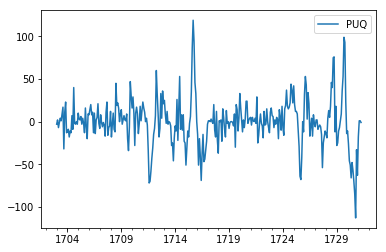

In [16]:
# work 2. make diff of 24 # lags = s * k
ts_05 = va_df_05['PUQ']
ts_diff_05 = ts_05.diff(24)
ts_diff_05.dropna(inplace = True)  #not work ????why
fig1 = plt.figure()
ax = fig1.add_subplot(111)
ts_diff_05[0:340].plot()
legend = ax.legend()

In [17]:
# work 3. check ACF PACF of ts_diff
#plot_acf(ts_diff_05, lags = 200)
#plot_pacf(ts_diff_05, lags = 700)

# ARIMA(1,0,3) * (3(4), 0, 2(7)) 24

In [18]:
# work 3. fit model using original ts[:-100].
# last 100 points seemed as test_data
pdq_05 = (1,0,3)
PDQ_05 = (4,1,4,24)

test_point_05 = 150
train_point_05 = len(ts_05) - test_point_05 # 620 - 24
train_05, test_05 = ts_05[:train_point_05], ts_05[train_point_05 :] #divide data into train_set and test_set

# fit model and predict
model_train_05 = SARIMAX(train_05, order = pdq_05, seasonal_order = PDQ_05 ).fit() # fitted model for predicting
predict_train_05 = model_train_05.fittedvalues # prediction on train test
predict_test_05 = model_train_05.forecast(test_point_05)  #  prediction on test set
predict_all_arima_05 = model_train_05.fittedvalues.append(predict_test_05) # predict on all data set (including train and test )

c:\users\ctbri\gc\python3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


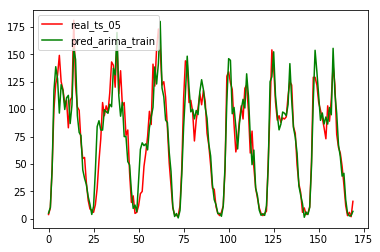

In [19]:
# in-sample results

plt.plot(ts_05.values[100:270], color = 'red', label = 'real_ts_05')
plt.plot(predict_train_05.values[100:270], color = 'green', label = 'pred_arima_train')
#plt.plot(predict_train.values[24:200], color = 'green', label = 'lag_pred_arima')
plt.legend(loc = 'upper left')

In [20]:
# in-sample error rate
# only SARIMA
np.mean(abs(ts_05[100:train_point_05]-predict_train_05[100:train_point_05])/ts_05[100:train_point_05])

0.24756987104375994

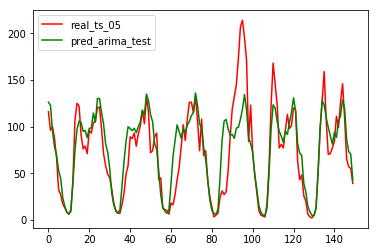

In [21]:
# out-of-sample results

plt.plot(ts_05.values[-test_point_05:], color = 'red', label = 'real_ts_05')
plt.plot(predict_test_05.values[-test_point_05:], color = 'green', label = 'pred_arima_test')
#plt.plot(predict_train.values[24:200], color = 'green', label = 'lag_pred_arima')
plt.legend(loc = 'upper left')

In [22]:
# out-of-sample error rate
# only SARIMA
np.mean(abs(ts_05[-test_point_05:]-predict_test_05[-test_point_05:])/ts_05[-test_point_05:])

0.3628037116311668

In [23]:
# work. residual
# residual consists of both train and test part of ARIMA
residual_05 =  ts_05 - predict_all_arima_05 
residual_05 = residual_05[100:]

n = 25 # how to set???
residual_list_05 = []
for i in np.arange(n - 1,  len(residual_05)):
    for j in np.arange( -(n - 1),  1):
        residual_list_05.append(residual_05[i + j] ) # len = 14900

# pre-processing for svm
df_residual_05 = pd.DataFrame()
df_residual_05 = df_residual_05.append( pd.DataFrame( np.array(residual_list_05).reshape( len(residual_05) - (n - 1),   n ) ) )
df_residual_05.index = residual_05[n - 1:].index
matrix_residual_05 = df_residual_05.as_matrix()

len(matrix_residual_05),len(matrix_residual_05[0])

(620, 25)

In [24]:
type(matrix_residual_05)

numpy.ndarray

In [25]:
df_residual = pd.DataFrame()
df_residual = df_residual_05.append(df_residual_06)   # May and June
matrix_residual =  df_residual_05.as_matrix()

In [26]:
# divide residual data into data_train and data_test. last train_rate(percent) rows of matrix.
# last column is y(output)
train_rate = 0.75
data_train = matrix_residual[:int(train_rate * len(matrix_residual)),  :]
data_test = matrix_residual[ int(train_rate * len(matrix_residual)):,  :] 

x_train = data_train[:, 0:n - 1]
y_train = data_train[:, n - 1]
x_test = data_test[:, 0: n - 1]
y_test = data_test[:, n - 1]

In [27]:
# fit model for svm 
#model_svm = svm.SVR(kernel = 'rbf')
#model_svm.fit(x_train, y_train)
#y_pred = model_svm.predict(x_test)
#y_pred_train = model_svm.predict(x_train[-(550 - test_point_06):])


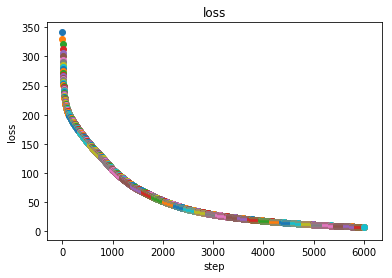

7.760285


In [78]:
"""tf_x = tf.placeholder(tf.float32,x_train.shape)     # input x
tf_y = tf.placeholder(tf.float32,y_train[:,np.newaxis].shape)     # input y"""

tf_x = tf.placeholder(tf.float32,[None,24])     # input x
tf_y = tf.placeholder(tf.float32,[None,1])
# neural network layers
l1 = tf.layers.dense(tf_x, 24, tf.nn.relu)          # hidden layer
output = tf.layers.dense(l1, 1)  
loss = tf.losses.mean_squared_error(tf_y, output)   # compute cost
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0001)
train_op = optimizer.minimize(loss)

sess = tf.Session()                                 # control training and others
sess.run(tf.global_variables_initializer())
         
#plt.ion()   # something about plotting
     
for step in range(6000):
    # train and net output
    a, l, pred = sess.run([train_op, loss, output], {tf_x: x_train, tf_y: y_train[:,np.newaxis]})
    #print(step,l)
    plt.scatter(step, l)
    plt.hold
    if step % 20 == 0:
        pass
    # plot and show learning process
        #plt.cla()
        # plt.scatter(x_tr, y)
        #plt.plot(y_train[-60:], 'r-')
        #plt.plot( pred[-60:], 'g' )
        #plt.text(0.5, 0, 'Loss=%.4f' % l, fontdict={'size': 20, 'color': 'red'})
        #plt.pause(0.1)
        


#plt.ioff()
plt.title('loss')
plt.xlabel('step')
plt.ylabel('loss')
plt.show()
print(l)
        # plot and show learning process



In [83]:
len(pred),pred[0].tolist()

(465, [3.836472272872925])

In [59]:
y_pred_tmp = sess.run([output], {tf_x: x_test})

In [56]:
y_pred[0][1].tolist()

[-8.201067924499512]

In [66]:
y_pred = []
for item in y_pred_tmp[0]:
    y_pred.append(item.tolist()[0])

In [67]:
len(y_pred)

155

In [70]:
y_pred_train_tmp = sess.run([output], {tf_x: x_train[-(550 - test_point_06):]}) 

In [84]:
y_pred_train = []
for item in pred:
    y_pred_train.append(item.tolist()[0])

In [87]:
len(y_pred_train)

465

In [31]:
#y_train

In [131]:
#y_train[:,np.newaxis]

In [47]:
type(x_train[0][0])

numpy.float64

In [27]:
"""from sklearn.tree import DecisionTreeRegressor
model_tree = DecisionTreeRegressor(max_depth = 3)
model_tree.fit(x_train, y_train)
y_pred = model_tree.predict(x_test)"""


'from sklearn.tree import DecisionTreeRegressor\nmodel_tree = DecisionTreeRegressor(max_depth = 3)\nmodel_tree.fit(x_train, y_train)\ny_pred = model_tree.predict(x_test)'

In [28]:
len(y_pred_train)

400

In [29]:
#y_hybrid_06 = y_pred[-124:] + predict_test_06[-124:]

In [88]:
y_hybrid_06 = y_pred[-test_point_06:] + predict_test_06[-test_point_06:]
y_hybrid_train_06 = y_pred_train[-400:] + predict_all_arima_06[-550:-test_point_06]

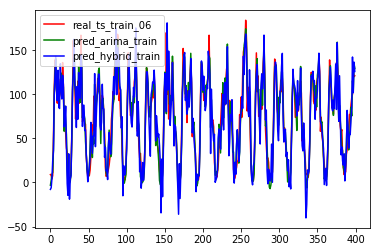

In [91]:
# in-sample  hybrid results
plt.plot(ts_06.values[-550:-test_point_06],  color = 'red', label = 'real_ts_train_06')
plt.plot(predict_all_arima_06.values[-550:-test_point_06], color = 'green', label = 'pred_arima_train')
plt.plot(y_hybrid_train_06.values, color = 'blue', label = 'pred_hybrid_train')
plt.legend(loc = 'upper left')

In [92]:
# in-sample error
np.mean(abs(ts_06[-550:-test_point_06]-y_hybrid_train_06[:])/ts_06[-550:-test_point_06])

0.7559038970014522

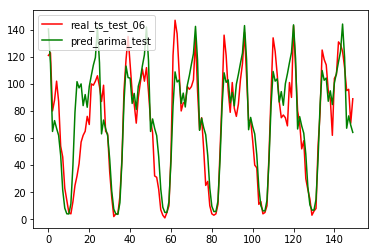

In [102]:
# out-of-sample results

plt.plot(ts_06.values[-test_point_06:], color = 'red', label = 'real_ts_test_06')
plt.plot(predict_test_06.values[-test_point_06:], color = 'green', label = 'pred_arima_test')
#plt.plot(y_hybrid_06.values[-test_point_06:], color = 'blue', label = 'pred_hybrid_test')
plt.legend(loc = 'upper left')

In [94]:
# out-of-sample error rate
# SARIMA + SVM
np.mean(abs(ts_06[-test_point_06:]-y_hybrid_06[-test_point_06:])/ts_06[-test_point_06:])

1.4009857789292868

In [ ]:
np.mean([])